## Описание проекта и задач

Банк столкнулся с высоким оттоком клиентов. Анализ позволит определить, какие клиенты уходят из банка, а так же поможет  составить сегменты клиентов, которые склонны уходить из банка.

Необходимо **выявить причины оттока клиентов банка и факторы, на это влияющие**. 

Датасет содержит данные о клиентах банка.

Структура данных:
- userid — идентификатор пользователя,
- score — баллы кредитного скоринга,
- City — город,
- Gender — пол,
- age — возраст,
- equity — количество баллов собственности
- balance — баланс на счёте,
- products — количество продуктов, которыми пользуется клиент,
- сredit_сard — есть ли кредитная карта,
- last_activity — активный клиент,
- est_salary — заработная плата клиента,
- Churn — ушёл или нет.

**Необходимо:**
- найти факторы, связанные с отточностью
- проверить гипотезы взаимосвязи переменных с отточностью
- выделить высокоотточные сегменты клиентов
- дать рекомендации по снижению уровня оттока 


### Оглавление

* [Загрузка данных. Импорт библиотек](#download)
* [Предобработка данных](#first)
    * [Корректировка названия столбов и типов данных, приведение данных к общему виду](#correct)
    * [Работа с пропусками ](#full)
    * [Распределения переменных. Изучение выбросов, аномалий](#outliers)
* [Исследовательский анализ](#research)
    * [Выявление признаков, влияющих на отток + Проверка гипотез о наличии взаимосвязи с отточностью](#infl)
    * [Составление портретов клиентов, склонных и не склонных к уходу ](#portrait)
    * [Категоризация переменных ](#categories)
    * [Определение показателя среднего оттока клиентов  ](#avg_churn)
* [Сегментация клиентов](#segments)
    * [Объединение отточных признаков, выделение и описание отточных сегментов](#churn_cl)
    * [Отбор сегментов с наивысшим оттоком + Рекомендации по удержанию](#segm_examples)
* [ОБЩИЙ ВЫВОД](#sum)

### Загрузка данных. Импорт библиотек <a class="anchor" id="download"></a>

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np 

from scipy import stats as st
import math as mth
!pip install phik 
import phik
import itertools


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
data = pd.read_csv('bank_churn.csv')

In [3]:
data.drop (columns=data.columns[0], axis= 1 , inplace= True )

## Предобработка данных  <a class="anchor" id="first"></a>

In [4]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


###  Корректировка названия столбов и типов данных, приведение данных к общему виду <a class="anchor" id="correct"></a>

Переименуем переменные, избавившись от верхнего регистра

In [6]:
data = data.rename(columns = {'USERID':'id',
                              'EST_SALARY':'est_salary'
                             })

Приведем все булевы переменные к соответствующему типу данных

In [7]:
data['credit_card'] = data['credit_card'].astype('bool')

data['last_activity'] = data['last_activity'].astype('bool')

data['churn'] = data['churn'].astype('bool')

In [8]:
data.duplicated().sum() 

0

Явных дубликатов нет

**id**

In [9]:
data['id'].duplicated().sum()

73

Видим, что в датасете есть 73 пользователя с одинаковым id. Изучим их

In [10]:
id_dup = data[data['id'].duplicated()]['id'].unique()

data.query('id in @id_dup').sort_values(by = 'id').head(10)

,id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.0,Рыбинск,Ж,55.0,1,362756.49,3,False,True,175920.48,True
7694,116540,887.0,Ярославль,Ж,38.0,0,NaN,1,False,True,119247.61,False
7542,117943,880.0,Ярославль,Ж,40.0,0,NaN,1,True,False,137718.93,False
4866,117943,855.0,Рыбинск,Ж,32.0,6,1036832.93,4,True,True,107792.71,True
5896,120258,905.0,Ярославль,М,30.0,0,NaN,1,True,True,146427.96,False
5863,120258,908.0,Рыбинск,Ж,38.0,4,2213581.63,2,False,True,160327.77,True
1411,123461,829.0,Ярославль,Ж,59.0,0,96222.44,2,False,True,102771.55,True
8638,123461,934.0,Рыбинск,М,34.0,0,NaN,2,True,False,291619.27,False
8164,124450,859.0,Ярославль,Ж,38.0,6,516811.20,1,True,True,95144.63,True
9775,124450,758.0,Рыбинск,Ж,36.0,0,73574.07,2,False,True,79963.59,False


In [11]:
data.query('id in @id_dup')['city'].value_counts()

Ярославль    73
Рыбинск      73
Name: city, dtype: int64

Можно было бы предположить, что это один и тот же пользователь, но имеющий несколько счетов в одном банке, однако мы видим, что у пользователей с одинаковым id разный возраст, а зачастую и пол. Соответственно, это разные люди. 
Города у таких пользователей либо Ярославль, либо Рыбинск. Вероятно, датасет сформирован посредством соединения баз данных различных филиалов, в результате которого некоторые id клиентов из Рыбинска и Ярославля дублируют друг друга. Также это может быть просто ошибка при выгрузке данных.
Исключим эти наблюдения, так как их менее 1% ( 0,73%)


In [12]:
data = data.drop_duplicates(subset='id')


**city**

In [13]:
data['city'].value_counts()

Ярославль    5856
Рыбинск      2654
Ростов       1417
Name: city, dtype: int64

Представлены данные из 3х городов, написание везде корректное, однотипное, опечаток нет.

**gender**

In [14]:
data['gender'].value_counts()


М    4972
Ж    4955
Name: gender, dtype: int64

Пола 2, обозначение однотипное, опечаток нет.

In [15]:
data['gender_dum'] = data['gender'].map(lambda x: 0 if x == 'М' else 1)

У остальных столбцов, судя по типу данных, все ок. Надо будет только проверить их в дальнейшем на выбросы

### Работа с пропусками  <a class="anchor" id="full"></a>

In [16]:
data.isna().sum()

id                  0
score               0
city                0
gender              0
age                 4
equity              0
balance          2260
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
gender_dum          0
dtype: int64

Пропуски есть только в 2х столбцах : age и balance. В age их крайне мало, поэтому просто отбросим их. Также, после исключения пропусков можно поменять тип столбца на int

In [17]:
data = data[data['age'].notna()]
data['age'] = data['age'].astype('int')

Пропусков в balance достаточно много (2260, что составляет около 23%), поэтому просто отбросить мы их не можем.

**Возможные причины пропусков:**
- ошибки при выгрузке
- нулевые остатки могли выгрузиться как пустые значения
- к информации о балансе каких-то  пользователей могло не быть доступа

Посмотрим, есть ли прямая зависимость между оценочной зарплатой и балансом на счету (возможно пропуски можно было бы заполнить, исходя из зарплаты).

In [18]:
data[data['balance'].isna()].head(10)

,id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_dum
2,120722,892.0,Рыбинск,Ж,30,0,NaN,1,True,True,107683.34,False,1
9,133130,906.0,Ярославль,Ж,67,0,NaN,1,False,True,238055.53,False,1
10,148929,927.0,Ростов,М,52,0,NaN,1,True,True,196820.07,False,0
11,172184,921.0,Ростов,М,41,0,NaN,1,True,True,217469.48,False,0
19,127034,922.0,Рыбинск,Ж,53,0,NaN,1,False,False,147094.82,False,1
21,177415,896.0,Рыбинск,Ж,47,0,NaN,1,False,False,225060.35,False,1
30,155730,946.0,Ярославль,Ж,47,0,NaN,2,True,True,660015.85,False,1
34,205226,944.0,Ярославль,М,35,0,NaN,2,True,True,239843.39,False,0
39,173175,924.0,Рыбинск,Ж,51,0,NaN,1,True,True,248844.47,False,1
43,228585,956.0,Ростов,М,41,0,NaN,1,True,False,115117.10,False,0


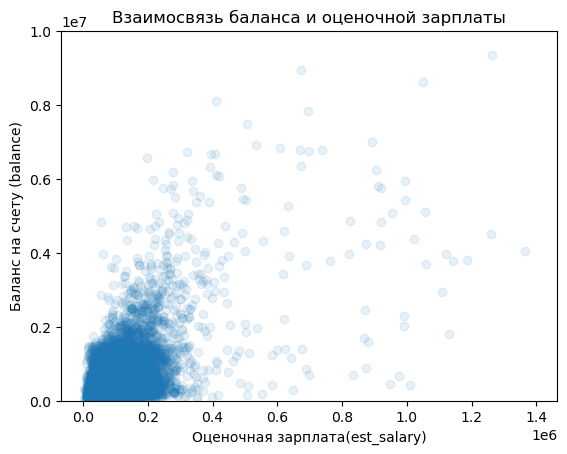

In [19]:
plt.scatter(data['est_salary'], data['balance'], alpha = 0.1)
plt.ylim(-50, 10000000)
plt.xlabel('Оценочная зарплата(est_salary)')
plt.ylabel('Баланс на счету (balance)')
plt.title('Взаимосвязь баланса и оценочной зарплаты')
plt.show()

In [20]:
data['balance'].corr(data['est_salary'])

0.3388388797378372

In [21]:
data[['est_salary','balance']].phik_matrix()

interval columns not set, guessing: ['est_salary', 'balance']


,est_salary,balance
est_salary,1.000000,0.374344
balance,0.374344,1.000000


На графике очевидной связи не наблюдается. Проверив коэф. корреляции Пирсона и phik, выяснили, что значения обоих коэф-тов интерпретируются как слабая связь. Поэтому заполнить пропуски balance на основании est_salary будет неверно

Посмотрим, сколько среди пропусков отточных клиентов 

In [22]:
data[data['balance'].isna()]['churn'].value_counts()

False    2247
True       13
Name: churn, dtype: int64

Большая часть пропусков баланса у неотточных клиентов. Поэтому **оставим пропуски**, как есть - **для изучения отточных клиентов они нам не сильно помешают**. Более того,остаток на счету мало от чего зависящая величина. Самая очевидная и сильная связь с заработной платой. Однако, даже Если человек зарабатывает много, это не значит, что он обязательно будет хранить эти деньги на счету (и именно в этом банке). Все зависит от отношения человека к деньгам и его склонности к способу распоряжения ими. Поэтому заполнить пропуски на основании чего-то будет, на мой взгляд, слишком приблизительно и не достоверно


Исключим лишь тех 13, кто собрался уходить, и кого нет информации о балансе


In [23]:
data = data[~((data['balance'].isna()) & (data['churn'] == True))]

### Распределения переменных. Изучение выбросов, аномалий <a class="anchor" id="outliers"></a>

In [24]:
def hist_box_plt (x, bins = 0):
    """
    Функция вывода гистограммы, диаграммы размаха ,
    а также основных статистик для количественных переменных
    """

    plt.figure(figsize=(20, 8))
    if bins >0:
        sns.histplot(x= x, data = data, bins = bins, ax = plt.subplot(1, 2, 1))
    else:
        sns.histplot(x= x, data = data, ax = plt.subplot(1, 2, 1))
    plt.ylabel('Частота')
    plt.title(f'Гистограмма {x}')
    
    data[[x]].boxplot(ax = plt.subplot(1, 2, 2))
    plt.title(f'Диаграмма размаха {x}')
    plt.ylabel('Значения')
    plt. suptitle(f'Гистограмма и диаграмма размаха для {x}')

    plt.show()
    
    display(data[x].describe())
    print('Медиана:',data[x].median())
    


**score**

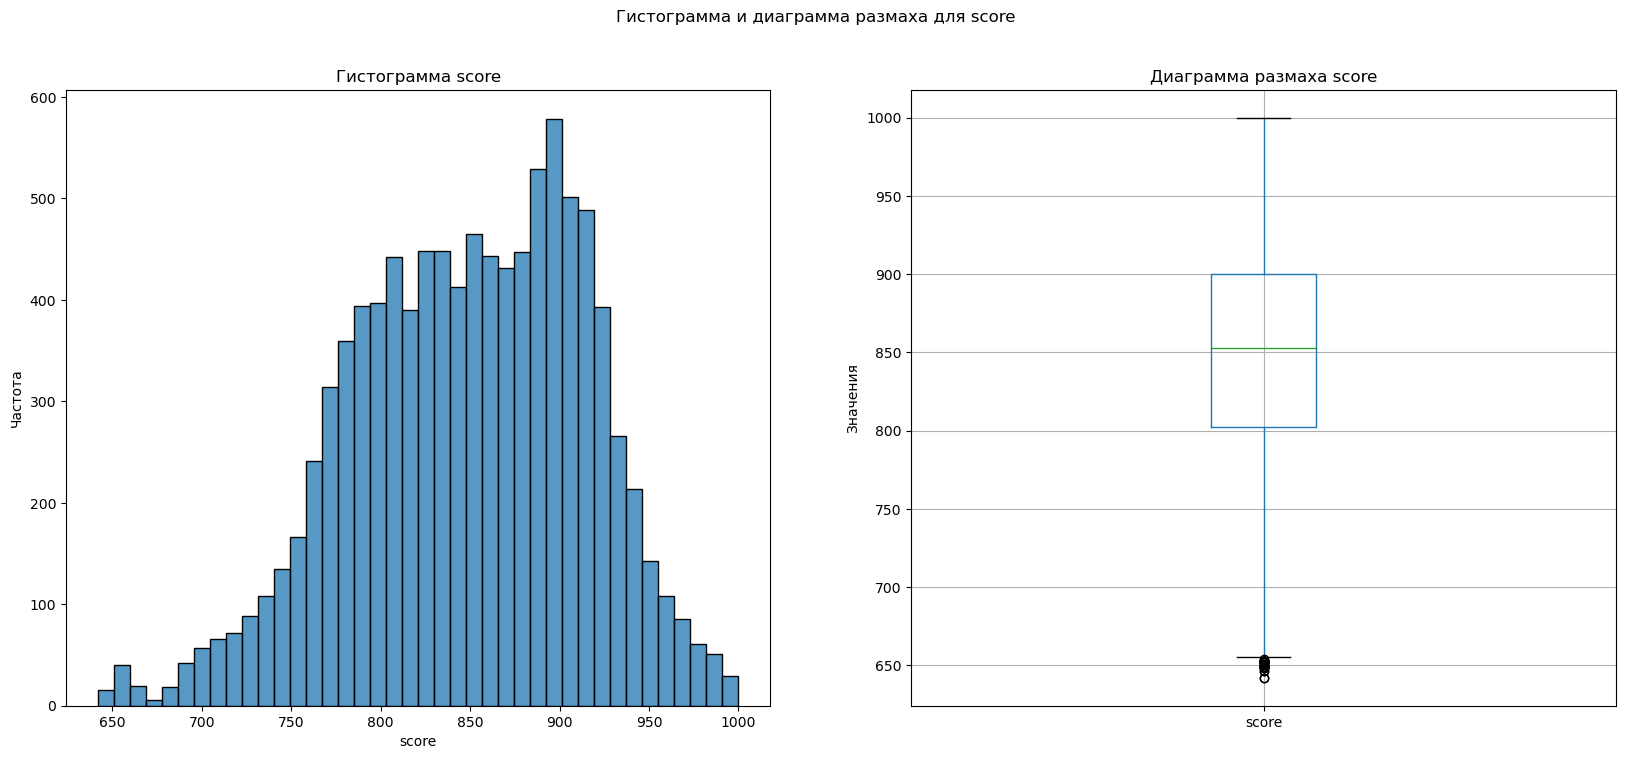

count    9910.000000
mean      848.739758
std        65.323219
min       642.000000
25%       802.000000
50%       853.000000
75%       900.000000
max      1000.000000
Name: score, dtype: float64

Медиана: 853.0


In [25]:
hist_box_plt('score')

Несмотря на то, что есть значения, лежащие дальше 1,5*IQR (межквартильный диапазон), по моему мнению, не стоит избавляться от таких наблюдений. Так как для анализа нам интересны как клиенты с высоким рейтингом, так и с низким. Поэтому выбросы не удаляем

**age**

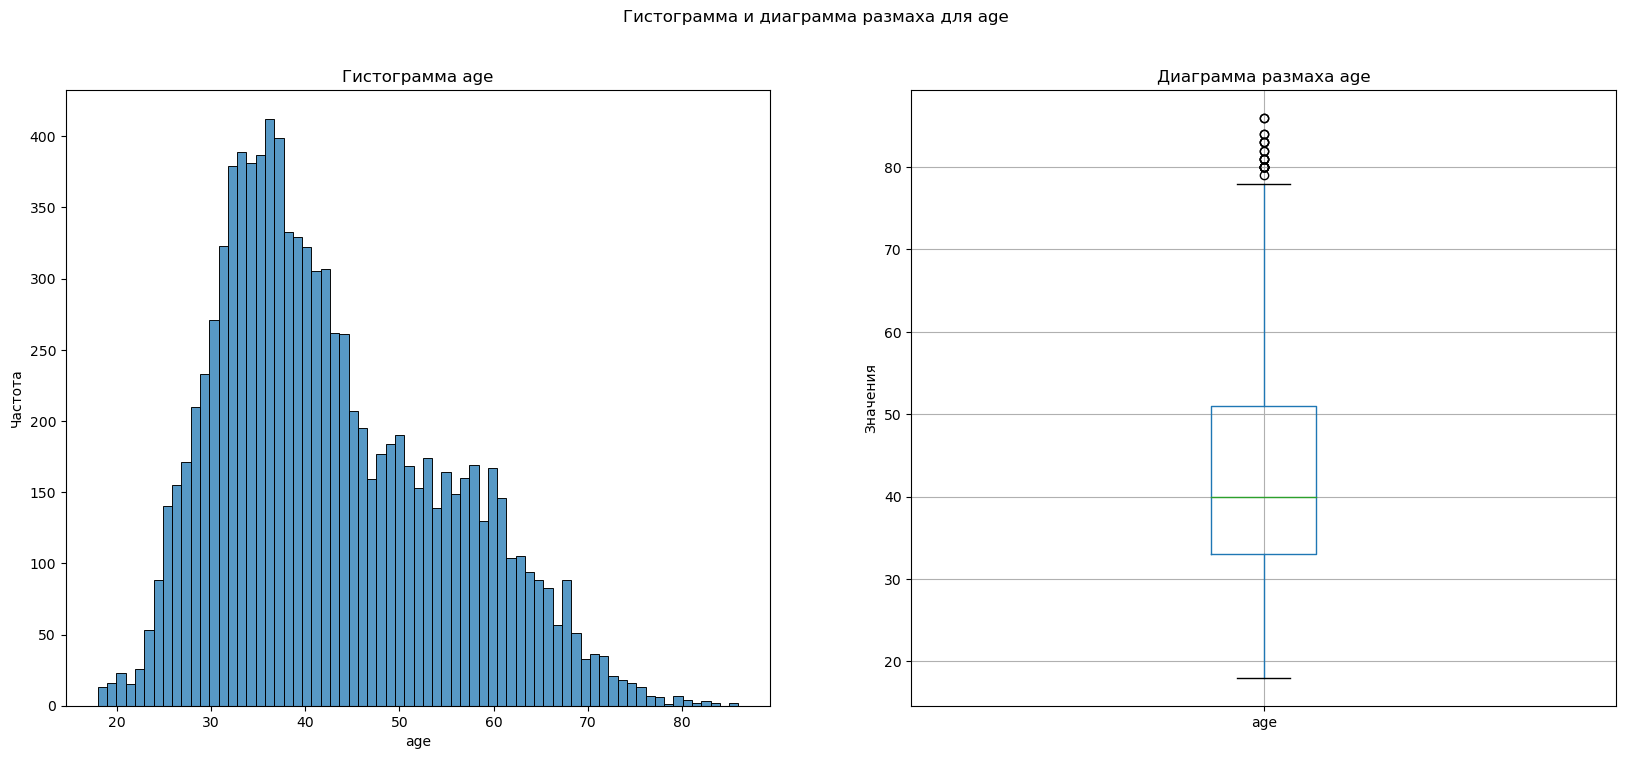

count    9910.000000
mean       42.722603
std        12.171415
min        18.000000
25%        33.000000
50%        40.000000
75%        51.000000
max        86.000000
Name: age, dtype: float64

Медиана: 40.0


In [26]:
hist_box_plt('age', 69)

Несмотря на то, что есть значения, лежащие дальше 1,5*IQR , по моему мнению, не стоит избавляться от таких наблюдений. Так как для анализа **нам интересны как молодые, так и более взрослые клиенты**. Очевидно, что чем глубже старость, тем меньше представителей этого возраста. Поэтому **выбросы не удаляем**, это вполне нормальная ситуация. 

Проверим дополнительно, чтобы не было клиентов младше 14 лет

In [27]:
data[data['age']<14]['id'].count()

0

**equity**

count    9910.000000
mean        2.637437
std         1.978498
min         0.000000
25%         0.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: equity, dtype: float64

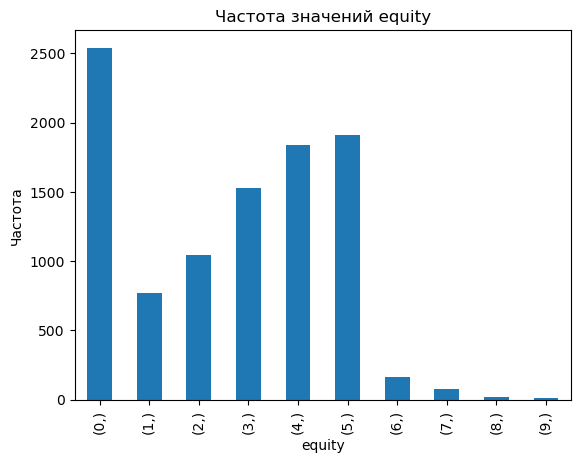

In [28]:
display(data['equity'].describe())
data[['equity']].sort_values(by='equity').value_counts(sort = False).plot(kind = 'bar')
plt.title('Частота значений equity')
plt.ylabel('Частота')
plt.show()

Самое распространение категориального показателя equity - 0, то есть люди без собственности. Меньше всего клиентов с высокой оценкой собственности (от 6 до 9 баллов), но их нельзя считать выбросами, так как это абсолютно нормальная ситуация - богатого населения значительно меньше, нежели бедного и среднего. Нас для анализа интересуют все слои населения, поэтому оставляем все как есть.

**balance**

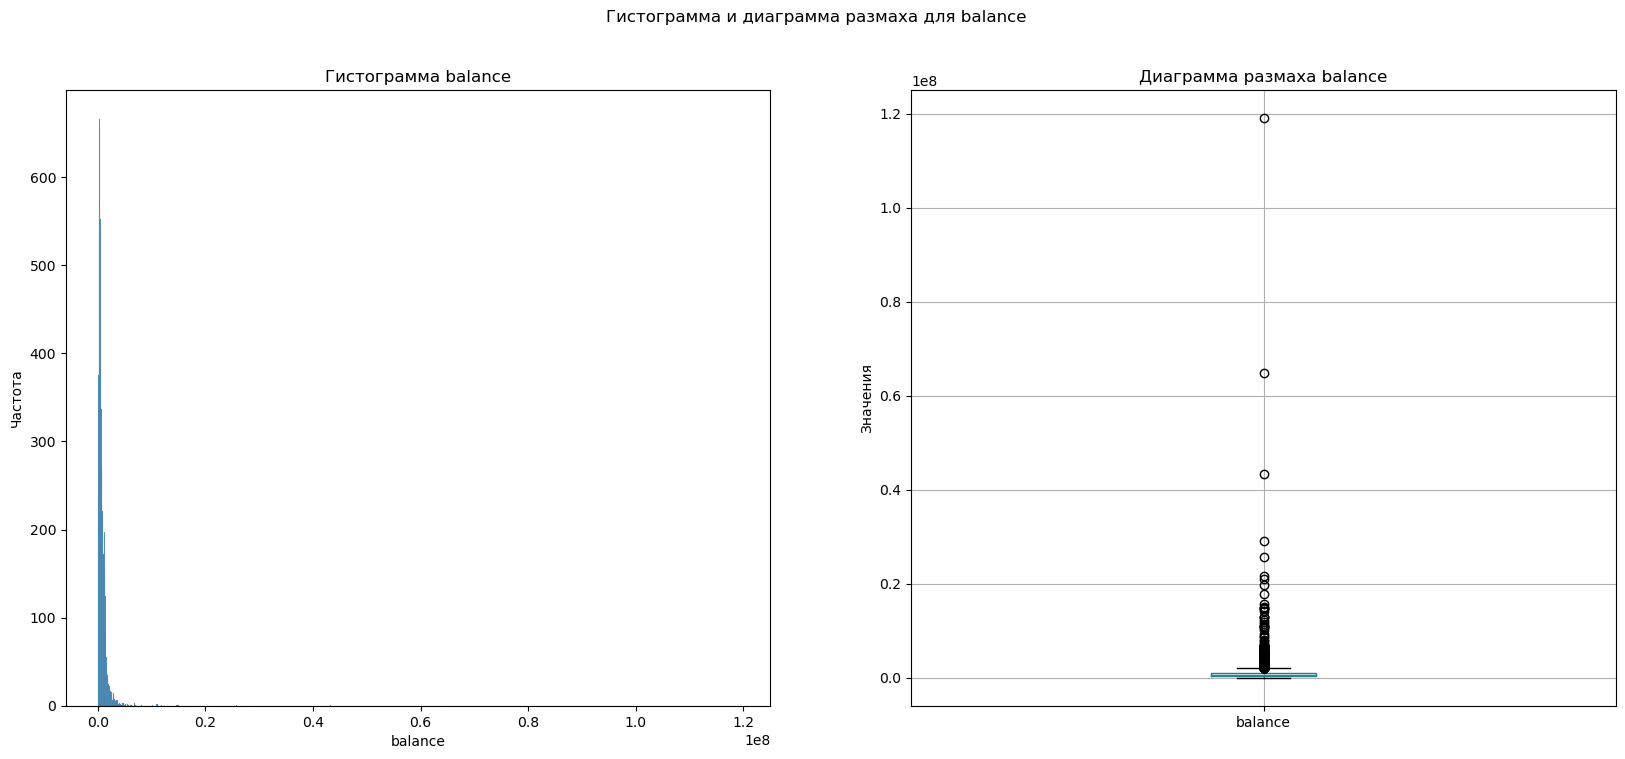

count    7.663000e+03
mean     8.282482e+05
std      1.984248e+06
min      0.000000e+00
25%      2.954990e+05
50%      5.249612e+05
75%      9.808015e+05
max      1.191136e+08
Name: balance, dtype: float64

Медиана: 524961.22


In [29]:
hist_box_plt('balance')

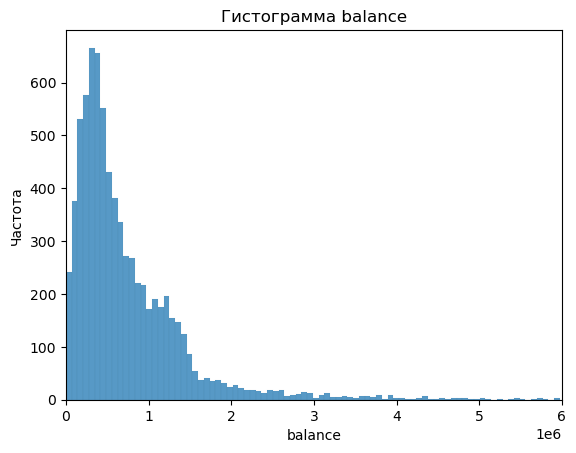

In [30]:
# посмотрим гистограмму поближе
sns.histplot(x= 'balance', data = data)
plt.ylabel('Частота')
plt.xlim(-1000, 6000000)
plt.title('Гистограмма balance')
plt.show()

Более 75% всех клиентов держат на счету до 1 млн руб. В среднем на счету хранится около 525 тыс руб. Наибольшее значение баланса - около 191 млн руб

По методу определения выбросов с помощью межквартильного диапазона очень много наблюдений попадают в категорию выбросов. Однако, абсолютно нормально, что у людей на счету в момент выгрузки данных могло лежать много денег (к примеру, получили наследство или продали квартиру/машину, и еще не успели распорядиться деньгами).  Поcмотрим на крайне выделяющиеся значения (верхний 1%), сколько среди них уходящих и остающихся.


In [31]:
np.percentile(data[data['balance'].notna()]['balance'],  99)

4827293.767

In [32]:
data[data['balance'] > np.percentile(data[data['balance'].notna()]['balance'],  99)]['churn']\
.value_counts()

False    50
True     27
Name: churn, dtype: int64

Среди клиентов, с крайне высоким остатком на счету , много тех, кто собрался уходить из банка. Поэтому отбрасывать их будет неправильно - **клиенты с большими деньгами всегда самые привлекательные для банка. Поэтому важно не исключать их из анализа.** Отбросим только крайне выдающиеся значения остатка (исходя из диаграммы размаха), у которых больше 20млн на балансе.

In [33]:
data[data['balance']>20000000]['id'].count()

7

In [34]:
data = data[~(data['balance']>20000000)]

**products**

count    9903.000000
mean        1.871756
std         0.792890
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: products, dtype: float64

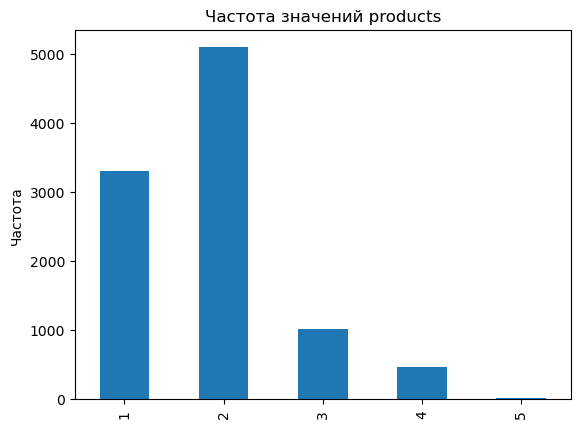

In [35]:
display(data['products'].describe())
data.sort_values(by='products')['products'].value_counts(sort = False).plot(kind = 'bar')
plt.title('Частота значений products')
plt.ylabel('Частота')
plt.show()

 Чаще всего клиенты имеют 2 банковских продукта. Тех, у кого их 5 - крайне мало. Одноко это так же в порядке нормы. Нулевых или отрицательных значений нет, что противоречило бы логике

**est_salary**

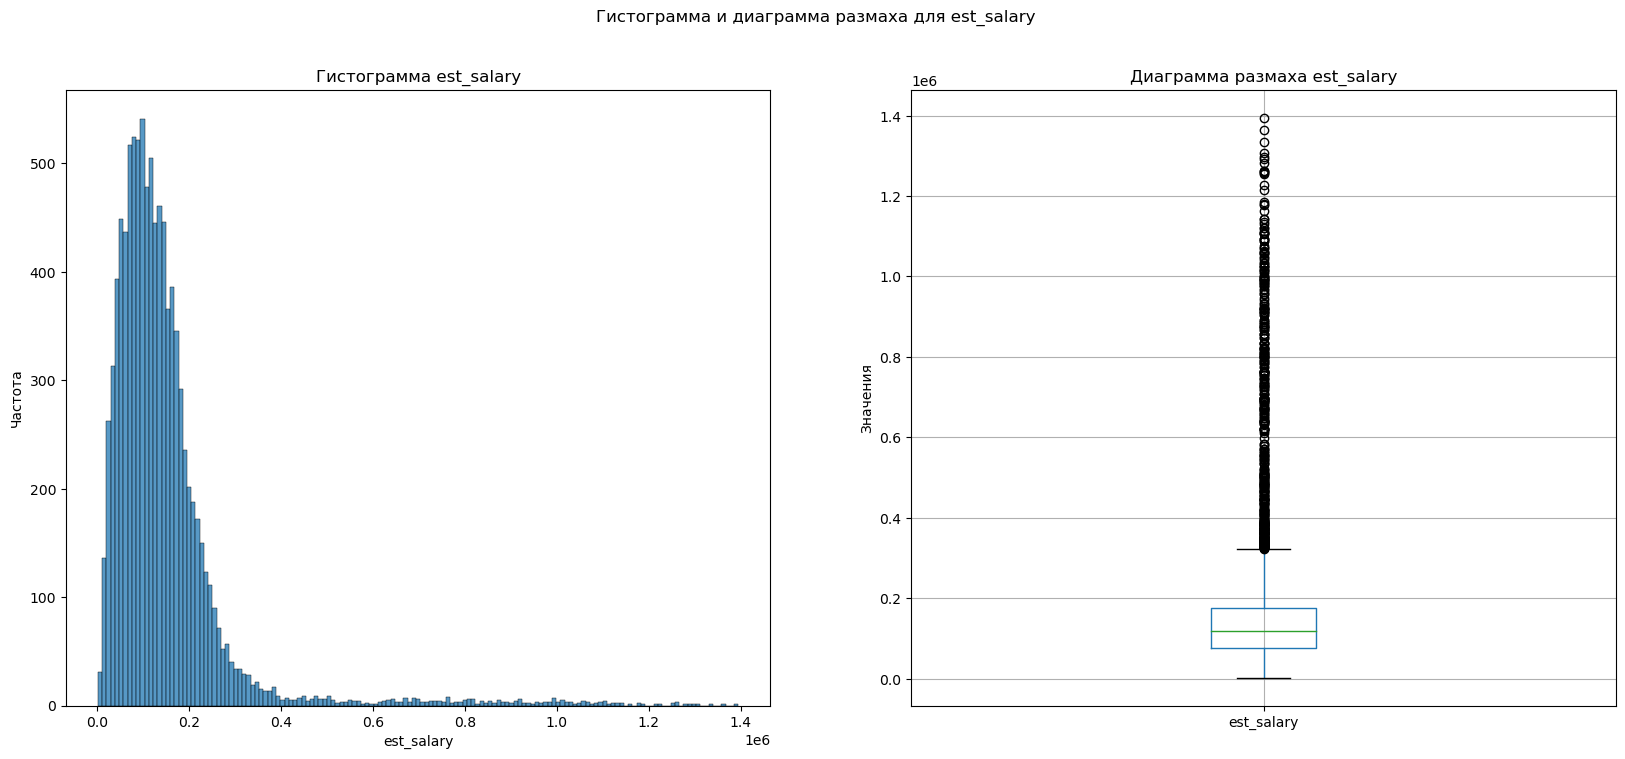

count    9.903000e+03
mean     1.474390e+05
std      1.383590e+05
min      2.546300e+03
25%      7.517802e+04
50%      1.195826e+05
75%      1.744957e+05
max      1.395064e+06
Name: est_salary, dtype: float64

Медиана: 119582.56


In [36]:
hist_box_plt('est_salary')

Аналогично балансу, по методу определения выбросов с помощью межквартильного диапазона очень много наблюдений попадают в категорию выбросов. Однако, **клиенты с высоких уровнем дохода более привлекательные для банка, и это нормально, что их не много. Поэтому предлагаю исключить из анализа только крайне выдающиеся значения зарплаты** (исходя из диаграммы размаха), которые больше 1,2млн. Проверим, чтобы среди них не было много отточных клиентов

In [37]:
data[data['est_salary'] > 1200000]['churn'].value_counts()

False    13
True      1
Name: churn, dtype: int64

In [38]:
data = data[~(data['est_salary']>1200000)]

**Вывод о полноте данных:** Баллы скоринга представлены от 642. Либо данные по менее надежным клиентам представлены не были, либо шкала оценивания кредитоспособности клиентов может быть скорректирована (если получить меньше баллов практически невозможно).

Во всем остальном неполноты данных замечено не было.

## Исследовательский анализ  <a class="anchor" id="research"></a>

### Выявление признаков, влияющих на отток + Проверка гипотез о наличии взаимосвязи с отточностью <a class="anchor" id="infl"></a>

Построим матрицу коэффициентов коррелляции phik

interval columns not set, guessing: ['score', 'age', 'est_salary', 'equity', 'balance', 'products']


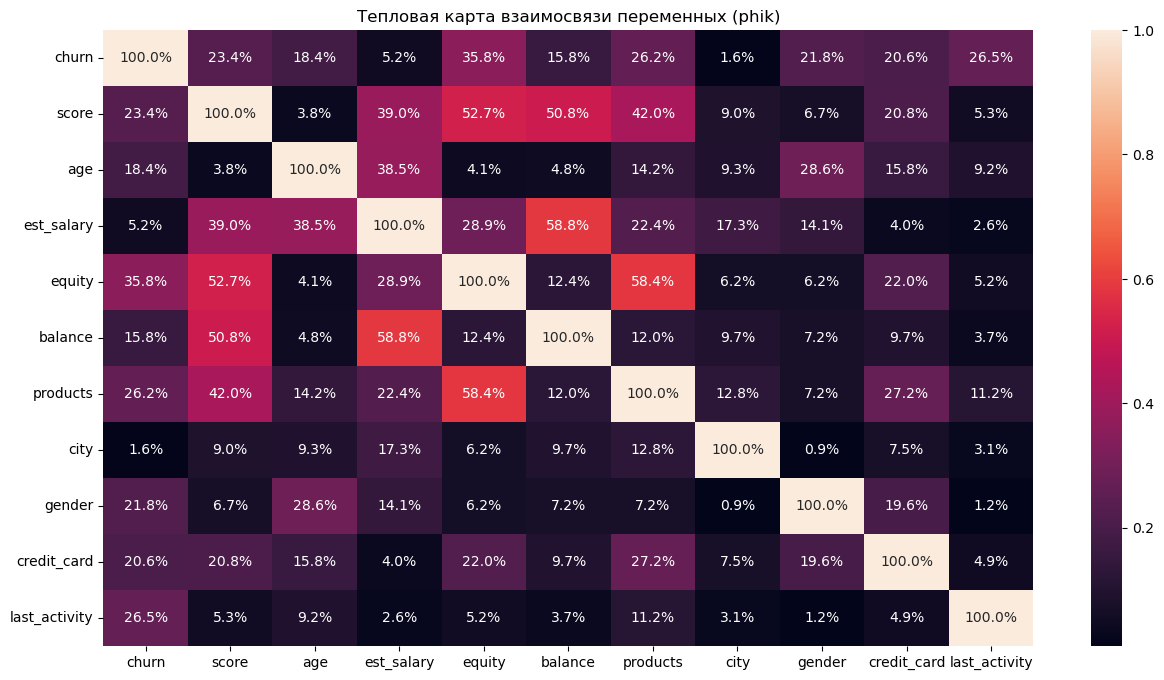

In [39]:
plt.figure(figsize = (15,8))
sns.heatmap(
    data[['churn','score', 'age', 
      'est_salary', 'equity', 
      'balance', 'products', 
      'city', 'gender', 
      'credit_card', 'last_activity']]\
.phik_matrix(),
    #.sort_values(by='churn', ascending = False)
    annot=True,  # включаем подписи
    fmt='.1%'
)
plt.title('Тепловая карта взаимосвязи переменных (phik)') 
plt.show()

Тепловая карта матрицы корреляций позволяет заметить наиболее высокие показатели взаимосвязи между оценкой собственности и кол-вом скоринговых баллов (equity и score 52,7%), кол-вом используемых продуктов банка и наличием кредитной карты в нем (equity и products 46,1%), оценкой собственности и кол-вом используемых продуктов банка (equity и products 44,2%).

Посмотрим отдельно на корреляцию оттока с другими параметрами.

interval columns not set, guessing: ['score', 'age', 'est_salary', 'equity', 'balance', 'products', 'gender_dum']


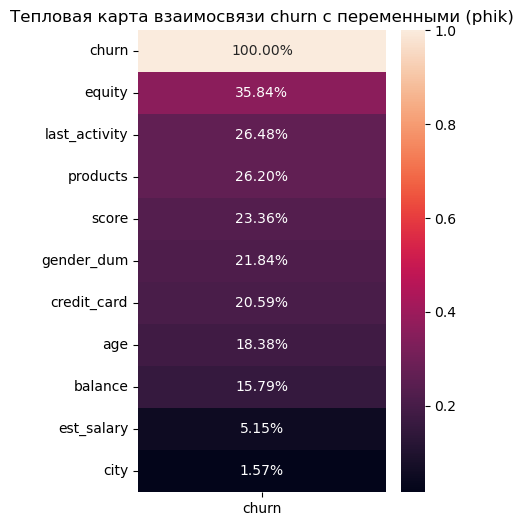

In [40]:
plt.figure(figsize = (4,6))
sns.heatmap(
    data[['churn','score', 'age', 
      'est_salary', 'equity', 
      'balance', 'products', 
      'city', 'gender_dum', 
      'credit_card', 'last_activity']]\
.phik_matrix()[['churn']].sort_values(by = 'churn', ascending = False),
    annot=True,  # включаем подписи
    fmt='.2%'
)
plt.title('Тепловая карта взаимосвязи churn с переменными (phik)') 
plt.show()

Наибольшее влияние на churn имеет оценка собственности клиента (equity, коэф. взаимосвязи 0,36).Стоит отметить, что такое значение коэф-та интерпретируется как умеренная связь.

Взаимосвязь положительная, то есть **чем выше оценка собственности, тем выше вероятность, что он уйдет**. 


Наименьшая взаимосвязь с оттоком у city и est_salary, ее практически нет. 

Дополнительно проверим статистическую значимость коэффициентов корреляции

In [41]:
for col in data[['churn','score', 
                 'age', 'est_salary', 
                 'equity', 'balance', 
                 'products', 'city', 'gender_dum', 
                 'credit_card', 'last_activity']].columns:
    
    pvalue = phik.significance.significance_from_array(data['churn'],data[col])[0]
    print(f'\n p-value  корреляции churn и {col} :{pvalue}')
    if pvalue <0.01:
        print('Корреляция значима')
    else: 
        print('Корреляция НЕзначима')



 p-value  корреляции churn и churn :0.0
Корреляция значима

 p-value  корреляции churn и score :5.114687719580469e-26
Корреляция значима

 p-value  корреляции churn и age :7.852631631017944e-41
Корреляция значима


/Users/natalafulga/anaconda3/lib/python3.10/site-packages/phik/data_quality.py:126: UserWarning: The number of unique values of variable y is large: 2. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(



 p-value  корреляции churn и est_salary :3.381824041690029e-126
Корреляция значима

 p-value  корреляции churn и equity :5.788995445896644e-183
Корреляция значима


/Users/natalafulga/anaconda3/lib/python3.10/site-packages/phik/data_quality.py:126: UserWarning: The number of unique values of variable y is large: 2. Are you sure this is not an interval variable? Analysis might be slow.
  warnings.warn(



 p-value  корреляции churn и balance :2.920980946381448e-287
Корреляция значима

 p-value  корреляции churn и products :2.0603580372498412e-193
Корреляция значима

 p-value  корреляции churn и city :0.012345584270204425
Корреляция НЕзначима

 p-value  корреляции churn и gender_dum :5.438128196627018e-45
Корреляция значима

 p-value  корреляции churn и credit_card :4.794179857435782e-38
Корреляция значима

 p-value  корреляции churn и last_activity :7.453820473583276e-67
Корреляция значима


Незначимость обнаружена только с параметром города (city)

**Рассмотрим подробнее взаимосвязь churn с количественными и качественными переменными.**

#### КОЛИЧЕСТВЕННЫЕ ПЕРЕМЕННЫЕ

In [42]:
def churn_dens(x, xlim=None,ylim=None, alpha=0.05 ):
    """
    Функция построения графика плотности вероятности для количественных переменных
    и определения наличия зависимости с churn. А также дополнительно диаграммы размаха
    по признаку churn
    """
    plt.figure(figsize=(15,8))
    sns.histplot(
        data = data, 
        hue = 'churn',
        x = x,
        stat = 'density',
        common_norm = False,
        palette = 'flag'
    )
    plt.title(f'График плотности вероятности {x} с учетом оттока ')
    plt.xlim(xlim)
    plt.show()
    
    
    print('\n T-тест для двух независимых выборок: ')
    print(f'\n H0: средние значения {x} у отточных и неотточных клиентов равны')
    print(f'\n H0: средние значениями {x} у отточных и неотточных клиентов не равны')
    result = st.ttest_ind(data[(data['churn'] == True) & (data[x].notna())][x],
                          data[(data['churn'] == False) & (data[x].notna())][x])
    print('\n p-value:',result[1])
    if result[1] < alpha:
        print(f'\n Отвергаем нулевую гипотезу: есть значимая разница между средними значениями {x} у отточных и неотточных клиентов')
    else:
        print(
            f'\n Не получилось отвергнуть нулевую гипотезу, нет оснований считать значимой разницу между средними значениями {x} у уходящих и остающихся клиентов '
        ) 
    
    plt.figure(figsize=(7,10))
    sns.boxplot(x='churn', y=x, data=data)
    plt.ylim(ylim)
    plt.title(f'Диаграмма размаха {x} по признаку ухода ')
    plt.show()

    
    

##### **age**

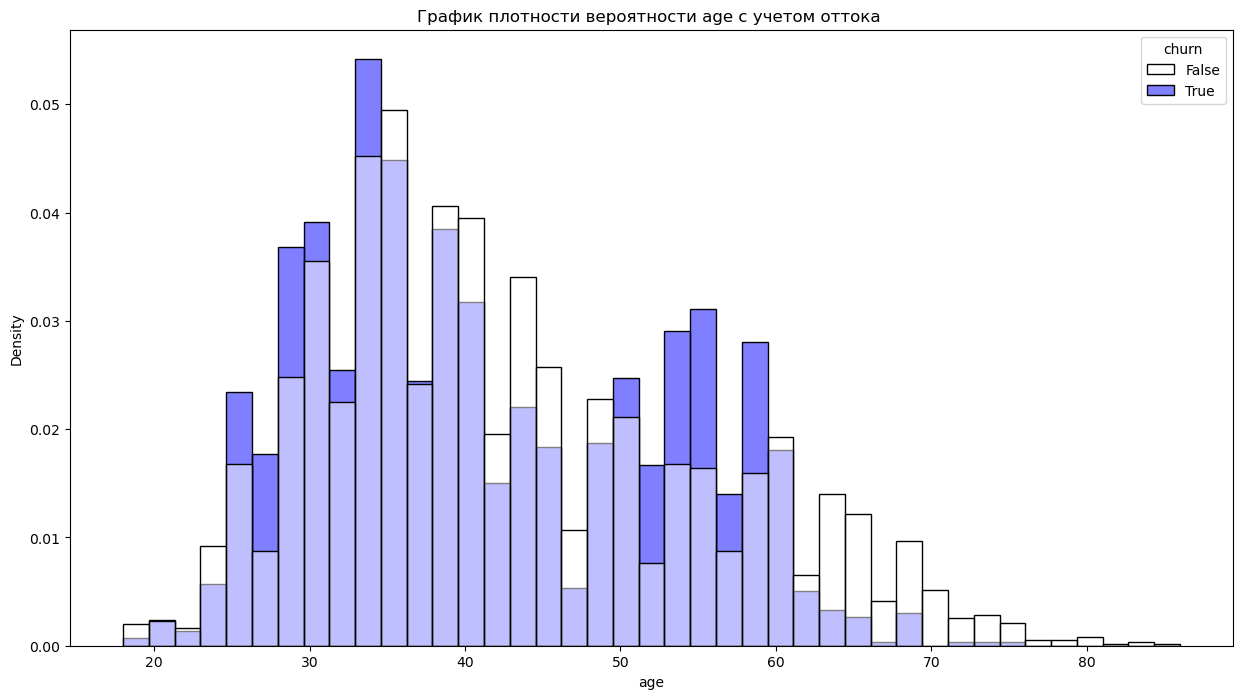


 T-тест для двух независимых выборок: 

 H0: средние значения age у отточных и неотточных клиентов равны

 H0: средние значениями age у отточных и неотточных клиентов не равны

 p-value: 3.4437978874480114e-07

 Отвергаем нулевую гипотезу: есть значимая разница между средними значениями age у отточных и неотточных клиентов


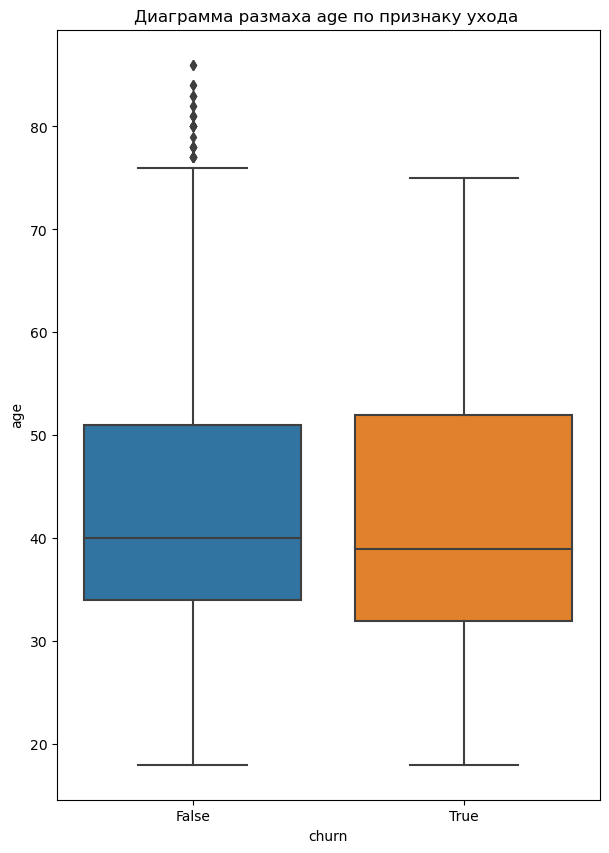

In [43]:
churn_dens('age')

Судя по графику плотности вероятности, в наибольшей степени к уходу склонны клиенты в возрасте от 25 до 34 лет, а также от 50 до 59 лет 

##### **balance**

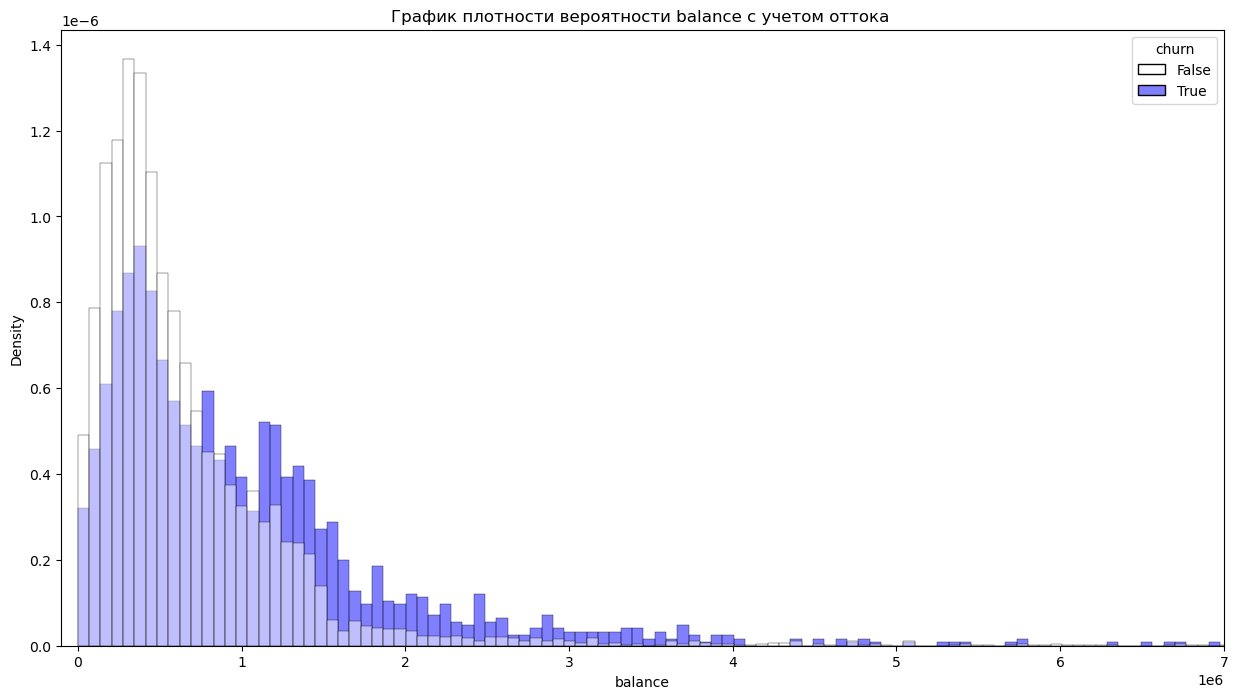


 T-тест для двух независимых выборок: 

 H0: средние значения balance у отточных и неотточных клиентов равны

 H0: средние значениями balance у отточных и неотточных клиентов не равны

 p-value: 5.813981719049295e-52

 Отвергаем нулевую гипотезу: есть значимая разница между средними значениями balance у отточных и неотточных клиентов


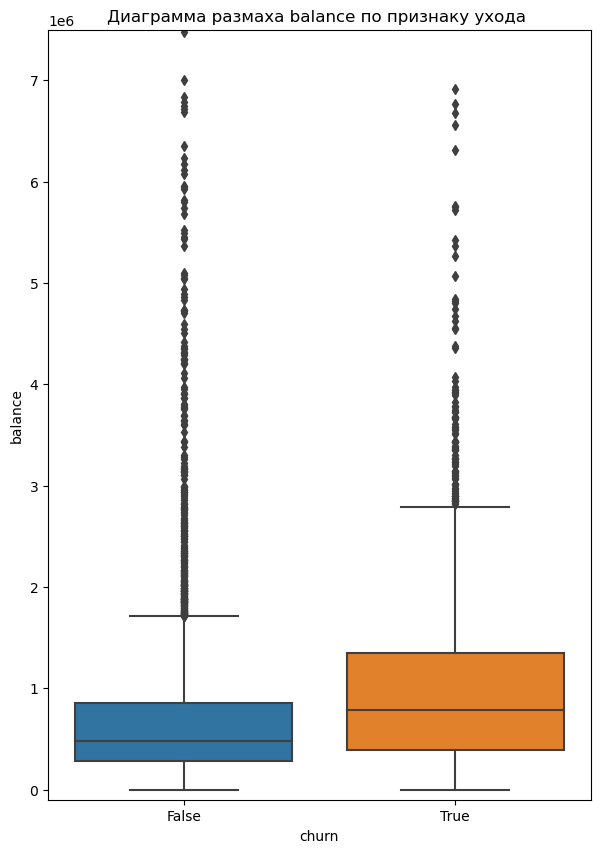

In [44]:
churn_dens('balance', (-100000, 7000000), (-100000, 7500000))

Из графика видим, что **клиенты с большим остатком на счету** ( примерно от 700 тыс руб) **более склонны к уходу**. 

Возможно, банку стоит **обратить внимание на условия по счетам**.

К примеру: 
- сделать бесплатным обслуживание, если остаток на счету выше определенной суммы 
- предложить начисление процента на остаток на счету (как в Тинькофф)
- проанализировать условия в других банках, сделать собственные условия конкурентными.

##### **est_salary**

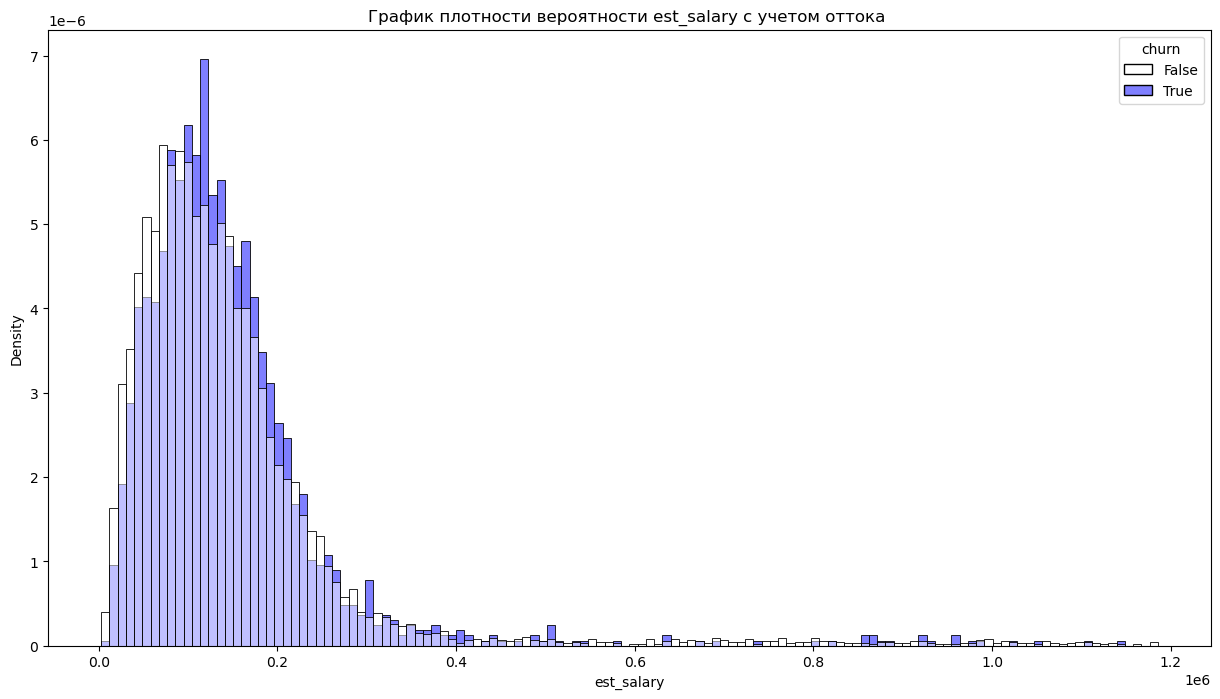


 T-тест для двух независимых выборок: 

 H0: средние значения est_salary у отточных и неотточных клиентов равны

 H0: средние значениями est_salary у отточных и неотточных клиентов не равны

 p-value: 0.9346553071279959

 Не получилось отвергнуть нулевую гипотезу, нет оснований считать значимой разницу между средними значениями est_salary у уходящих и остающихся клиентов 


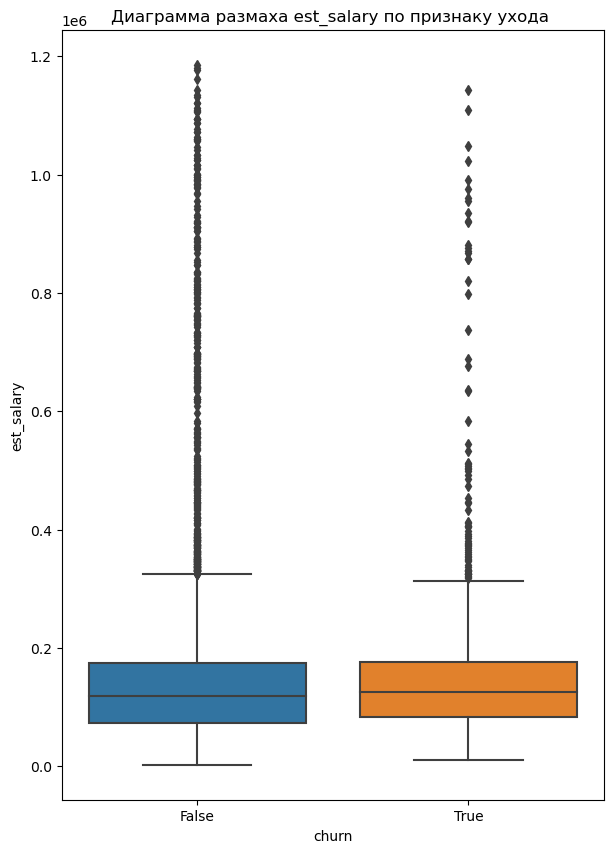

In [45]:
churn_dens('est_salary')

 Размер оценочной зарплата не влияет на отток клиентов. На графике размаха видно, что средние значения зарплаты тех кто уходит и остается, действительно, практически равны

##### **score**

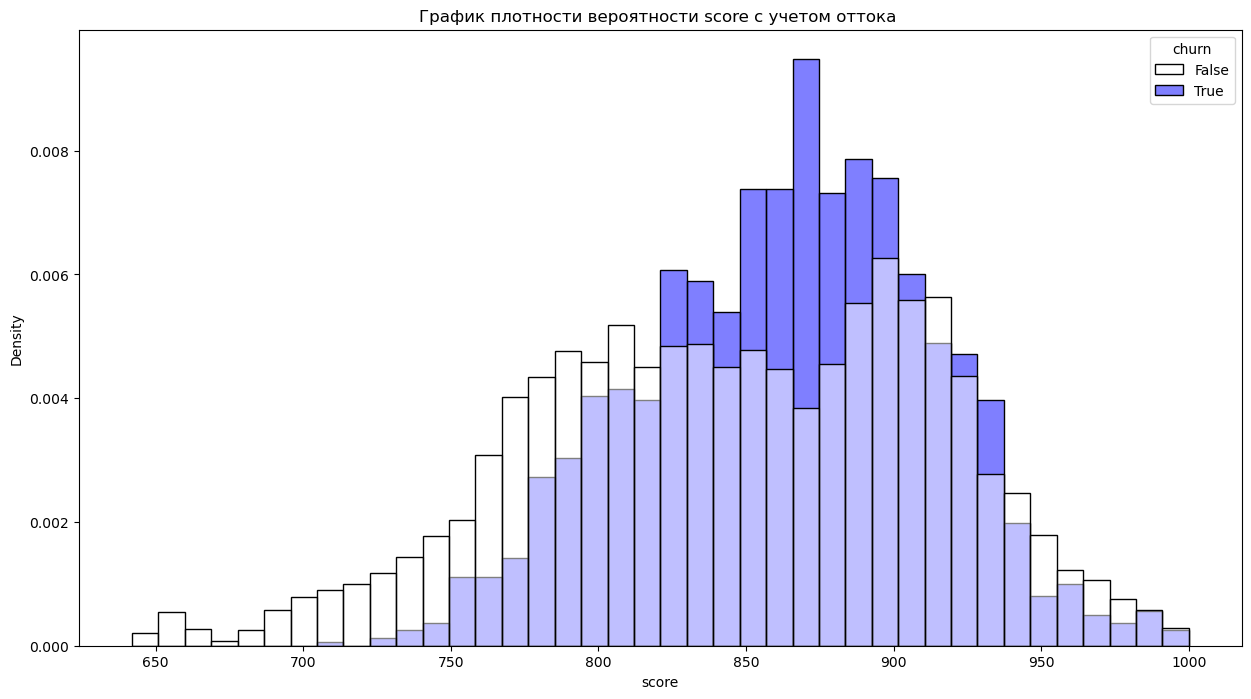


 T-тест для двух независимых выборок: 

 H0: средние значения score у отточных и неотточных клиентов равны

 H0: средние значениями score у отточных и неотточных клиентов не равны

 p-value: 1.0224974186847325e-26

 Отвергаем нулевую гипотезу: есть значимая разница между средними значениями score у отточных и неотточных клиентов


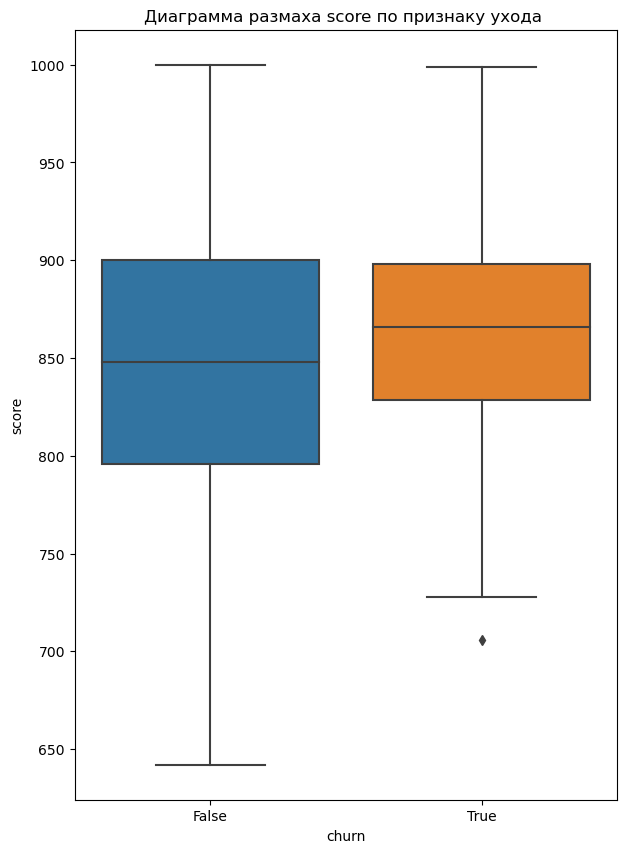

In [46]:
churn_dens('score')

Из графика плотности вероятности видим, что клиенты со средним скоринговым баллом ( примерно от 820 - 920 баллов) более склонны к уходу, нежели клиенты с низкими или высокими оценками. 

По диаграмме размаха заметно, что **скоринговый балл тех, кто принял решение уходить от банка в среднем выше, чем у тех, кто остается.**  Это свидетельствует о том, что более обеспеченые и благонадежные (с кредитной точки зрения) клиенты в большей степени склонны к уходу. А они - наиболее ценные клиенты для банка. 

#### **КАТЕГОРИАЛЬНЫЕ ПЕРЕМЕННЫЕ**

In [47]:
def bar_x2_churn (x, alpha=0.05):
    """
    Функция построения столбчатого графика доли уходящих (churn == True) 
    для качественных переменных
    и определения наличия зависимости с churn по критерию χ2
    """
    
    sns.barplot(x=x, y='churn', data=data, estimator = np.mean) 
    plt.title(f'Доля отточных клиентов по {x}')
    plt.show()

    churn_stat = data.pivot_table(index = x, 
                                    values = 'churn', 
                                    aggfunc = ['sum', 'count'])
    churn_stat.columns = ['sum_churn', 'total']
    churn_stat['not_churn'] = churn_stat['total'] - churn_stat['sum_churn']
    churn_stat['churn_share'] = churn_stat['sum_churn']/churn_stat['total']
    print(churn_stat)
    
    
    chi2 = st.chi2_contingency(churn_stat[['sum_churn', 'not_churn']])
    print('\n Критерий на независимость χ2 \n p-value: ',chi2[1])
    print(f'\n H0: {x} и отточность (churn) независимы')
    print(f'\n H0: {x} и отточность (churn) зависимы')
    
    print('Уровень значимости:', alpha)
    if chi2[1] < alpha:
        print(f'\n Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между {x} и churn')
    else:
        print(f'\n Не можем отвергнуть нулевую гипотезу о независимости переменных. Статистически значимой взаимосвязи между {x} и churn нет')
    


##### gender

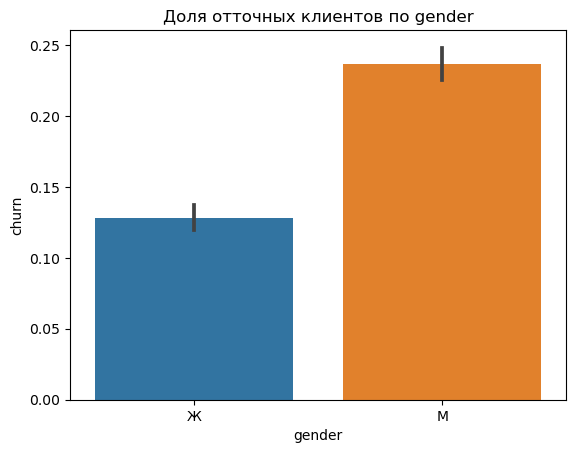

        sum_churn  total  not_churn  churn_share
gender                                          
Ж             633   4946       4313     0.127982
М            1170   4943       3773     0.236698

 Критерий на независимость χ2 
 p-value:  2.2480061116890096e-44

 H0: gender и отточность (churn) независимы

 H0: gender и отточность (churn) зависимы
Уровень значимости: 0.05

 Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между gender и churn


In [48]:
bar_x2_churn('gender')

**Отточных мужчин чуть ли не в 2 раза больше, чем женщин.** При чем общее количество мужчин и женщин примерно одинаковое. Ожидаемо, что Критерий на независимость χ2 подтвердил статистическую значимость зависимости пола и намерением уйти из банка.

**Между полом и отточностью есть зависимость.**
 
 С житейской точки зрения это можно в том числе объяснить тем, что мужчины чаще вовлечены в финансовые дела. За счет чего они чаще ищут более выгодные условия в банках и следят за текущих положением дел.

##### **city**

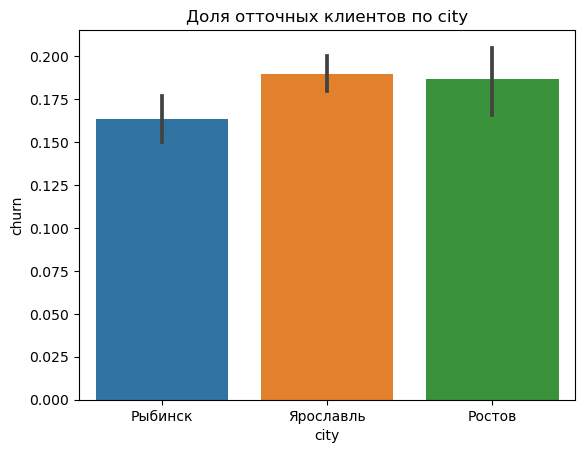

           sum_churn  total  not_churn  churn_share
city                                               
Ростов           264   1415       1151     0.186572
Рыбинск          433   2649       2216     0.163458
Ярославль       1106   5825       4719     0.189871

 Критерий на независимость χ2 
 p-value:  0.012769803977565814

 H0: city и отточность (churn) независимы

 H0: city и отточность (churn) зависимы
Уровень значимости: 0.01

 Не можем отвергнуть нулевую гипотезу о независимости переменных. Статистически значимой взаимосвязи между city и churn нет


In [49]:
bar_x2_churn('city', 0.01)

Доля отточных клиентов в Рыбинске ниже. В Ростове и Ярославле примерно одинаковая и чуть выше чем в Рыбинске.

Но разницу считаем незначительной.

##### **products**

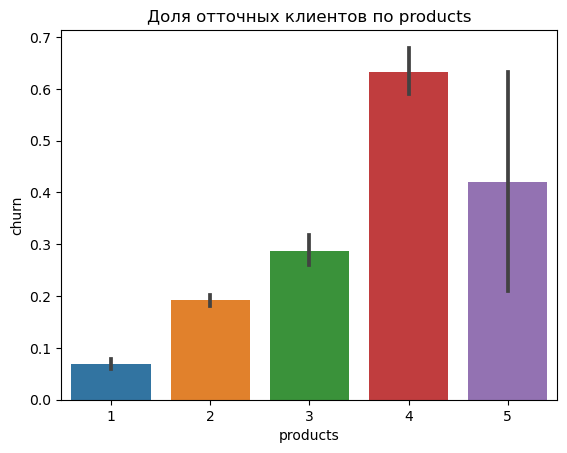

          sum_churn  total  not_churn  churn_share
products                                          
1               226   3289       3063     0.068714
2               975   5085       4110     0.191740
3               294   1022        728     0.287671
4               300    474        174     0.632911
5                 8     19         11     0.421053

 Критерий на независимость χ2 
 p-value:  8.807631676558914e-219

 H0: products и отточность (churn) независимы

 H0: products и отточность (churn) зависимы
Уровень значимости: 0.05

 Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между products и churn


In [50]:
bar_x2_churn('products', 0.05)

Наивысшая доля отточных клиентов у клиентов с 4-мя продуктами. Наблюдается общая **тенденция к росту доли отточности при росте количества используемых продуктов банка** (за исключением клиентов с 5-ю продуктами, но их кол-во невелико, поэтому статистика может быть недостоверной). 

H0: между кол-вом продуктов клиента и отточностью нет зависимости

H1: между кол-вом продуктов клиента и отточностью есть зависимость

при уровне значимости 0.05 отвергаем нулевую гипотезу о независимости переменных (так как p-value< 0.05), значит, **между кол-вом продуктов клиента и отточностью  есть зависимость.**

Это очень тревожащий показатель, говорящий о том, что **чем плотнее клиент взаимодействует с банком, тем выше вероятность, что он уйдет**. 

Возможные решения: 
- пересмотреть условия и бонусы для лояльных, верных клиентов, которые пользуются несколькими продуктами. Возможно, они недополучают должного внимания (плохо/долго обслуживаются) или банк не выполняет свои обязательства по продуктам.
- проанализировать на каких условия другие банки предлагают аналогичные продукты
- сделать конкурентное предложение для клиентов

Клиенты с большим количеством продуктов - также более ценные для банка. Поэтому стоит обратить внимание на выяленную закономерность

##### **credit_card**

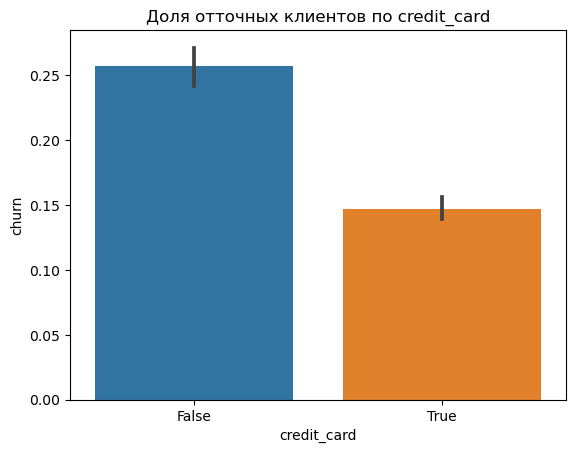

             sum_churn  total  not_churn  churn_share
credit_card                                          
False              814   3168       2354     0.256944
True               989   6721       5732     0.147151

 Критерий на независимость χ2 
 p-value:  1.3632101050594542e-39

 H0: credit_card и отточность (churn) независимы

 H0: credit_card и отточность (churn) зависимы
Уровень значимости: 0.05

 Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между credit_card и churn


In [51]:
bar_x2_churn('credit_card', 0.05)


При уровне значимости 0.05 отвергаем нулевую гипотезу о независимости переменных (так как p-value< 0.05), значит, между наличием кредитной карты и отточностью есть зависимость.

**Клиенты, у которых нет кредитной карты, в большей степени склонны к уходу, нежели те, у кого она есть.**

Соответственно, можно использовать этот инструмент для удержания клиентов - предлагать им кредитную карту. Вероятно, условия по ней достаточно выгодные для клиентов.

##### **last_activity**

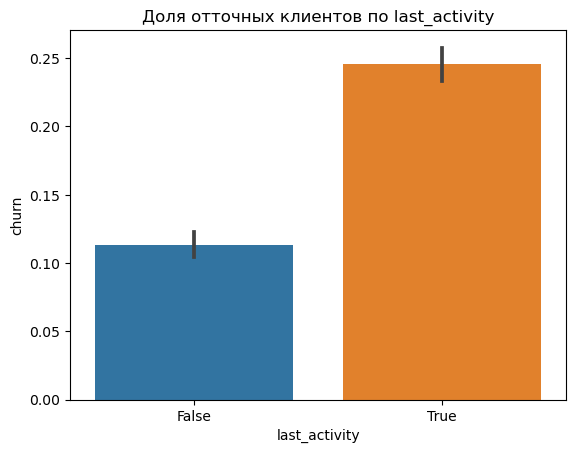

               sum_churn  total  not_churn  churn_share
last_activity                                          
False                532   4708       4176     0.112999
True                1271   5181       3910     0.245319

 Критерий на независимость χ2 
 p-value:  9.087947691199109e-65

 H0: last_activity и отточность (churn) независимы

 H0: last_activity и отточность (churn) зависимы
Уровень значимости: 0.05

 Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между last_activity и churn


In [52]:
bar_x2_churn('last_activity', 0.05)

При уровне значимости 0.05 отвергаем нулевую гипотезу о независимости переменных (так как p-value< 0.05), значит, между **активностью клиентов и отточностью есть зависимость.**

**Клиенты, которые были активны в последний месяц, в большей степени склонны к уходу, нежели те, у кто никаких операций не осуществлял.**

Это подтверждается и нашими жизненными знаниями. Много людей, кто просто открыл счет/карту и не пользуется ими. Ведь чтобы закрыть счет/карту необходимо прийти, написать заявление, пройти все необходимые процедуры. На что зачастую у клиентов нет времени/ сил/желания.

##### **equity**

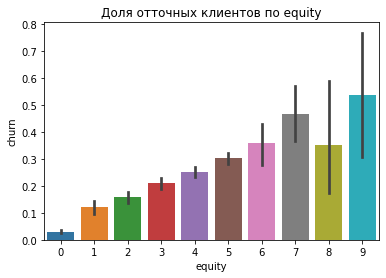

        sum_churn  total  not_churn  churn_share
equity                                          
0              78   2534       2456     0.030781
1              93    771        678     0.120623
2             166   1045        879     0.158852
3             321   1531       1210     0.209667
4             462   1837       1375     0.251497
5             575   1901       1326     0.302472
6              58    161        103     0.360248
7              37     79         42     0.468354
8               6     17         11     0.352941
9               7     13          6     0.538462

 Критерий на независимость χ2 
 p-value:  4.807250440675677e-157

 H0: equity и отточность (churn) независимы

 H0: equity и отточность (churn) зависимы
Уровень значимости: 0.05

 Отвергаем нулевую гипотезу о независимости переменных.Есть статистически значимая взаимосвязь между equity и churn


In [50]:
bar_x2_churn('equity', 0.05)

Видим, что **доля оттока растет по мере роста объема собственности клиентов**. Что-то обеспеченным, состоятельным клиентам не нравится в банке. 

**ВЫВОД:**

Была выявлена взаимосвязь со следующими количественными переменными: balance, score, age

А также с качественными и ранговыми переменными: gender, products, credit_card, last_activity, equity

Далее они будут использоваться для формирования сегмнтов и последующего анализа

### Составление портретов клиентов, склонных и не склонных к уходу <a class="anchor" id="portrait"></a>

Из проведенного выше анализа можно сделать вывод, что:

- В большей степени склонны к уходу: мужчины, с высоким остатком на счету, в возрасте 25-35 или 50-60 лет, с достаточно высокой скоринговой оценкой (820 - 920 баллов), с большим количеством продуктов банка (3-5 шт), но не имеющие кредитной карты в этом банке.

В меньшей степени склонны к уходу: 
- женщины, с низким остатком на счету, с низкой скоринговой оценкой, с одним продуктом банка, и имеющие кредитную карту в этом банке

### Категоризация переменных  <a class="anchor" id="categories"></a>

Не будем делить на большое количество групп, чтобы не получались слишком маленькие сегменты (менее 500 чел) в дальнейшем анализе. Ранее при анализе переменной возраста были выявлены точки смены тенденции поведения (25,35,50,60 лет). Разделим на возрастные группы в соответствии с ними.

**age**

In [53]:
data['age_gr'] = data['age'].map(lambda x: 
                                 'до 25 лет' if x < 25
                                 else '25-34 лет' if x < 35
                                 else '35-49 лет' if x < 50
                                 else '50-59 лет' if x < 60
                                 else 'от 60 лет' )

 **balance**

In [54]:
data['balance_gr'] = data['balance'].map(lambda x: 
                                         'до 700 тыс руб' if x < 700000
                                         else '700 тыс - 5 млн руб' if x < 5000000 
                                         else 'от 5 млн' )

 **score**

In [55]:
data['score_gr'] = data['score'].map(lambda x: 
                                         'до 820 баллов' if x < 820
                                         else '820 - 920 баллов' if x < 920 
                                         else 'от 920 баллов' )

 **products**
 
 Также создадим группы для кол-ва продуктов: 1,2,3-5

In [56]:
data['products_gr'] = data['products'].map(lambda x: 
                                         '1' if x == 1
                                         else '2' if x == 2
                                         else '3-4' )

 **equity**

In [57]:
data['equity_gr'] = data['equity'].map(lambda x: 
                                         '0-2' if x < 3
                                         else '3-5' if x < 6
                                         else '6-9' )

### Определение показателя среднего оттока клиентов <a class="anchor" id="avg_churn"></a>

In [58]:
ch_rate = data[data['churn'] == True]['id'].count()/data['id'].count()
print('Cредний отток клиентов:', ch_rate.round(4)*100, '%')

Cредний отток клиентов: 18.23 %


## Сегментация клиентов <a class="anchor" id="segments"></a>

### Объединение отточных признаков, выделение и описание отточных сегментов <a class="anchor" id="churn_cl"></a>

In [59]:
def segments_3 (var, high_churn_segm):
    """
    Функция, принимающая на вход список переменных (от 2 до 5 шт) и перебирающая комбинации их значений
    для выявления сегментов, в которых уровень оттока выше среднего. Те сегменты, в которых 500-2000 человек,
    и уровень оттока выше среднего - добавляются в таблицу high_churn_segm
    """
    
    var_num = len(var)
    high_churn_segm_list = []
    
    if 'balance_gr' in var:
        
        data_analyze = data[data['balance'].notna()]
    else:
        data_analyze = data
    
    #если переменные 2
    if var_num == 2:
        for v0 in  data_analyze[var[0]].unique():
            for v1 in  data_analyze[var[1]].unique():
                dt = data_analyze.loc[(data_analyze[var[0]] == v0) & (data_analyze[var[1]] == v1)]
                
                if dt['id'].count() > 0:
                        count = dt['id'].count()
                        ch = dt[dt['churn'] == True]['id'].count()/count

                        if (count>500) and (count<2001) and (ch > ch_rate):
                    
                            high_churn_segm_list.append([var, [v0,v1],count, ch])
                
                    
                
    
    #если переменные 3   
    elif var_num == 3:
        for v0 in  data_analyze[var[0]].unique():
            for v1 in  data_analyze[var[1]].unique():
                for v2 in  data_analyze[var[2]].unique():
                    dt = data_analyze.loc[(data_analyze[var[0]] == v0) & 
                                  (data_analyze[var[1]] == v1) & 
                                  (data_analyze[var[2]] == v2)]
                    if dt['id'].count() > 0:
                        count = dt['id'].count()
                        ch = dt[dt['churn'] == True]['id'].count()/count

                        if (count>500) and (count<2001) and (ch > ch_rate):
        
                            high_churn_segm_list.append([var, [v0,v1,v2],count, ch])
                
                    
    
    #если переменные 4   
    elif var_num == 4:
        for v0 in  data_analyze[var[0]].unique():
            for v1 in  data_analyze[var[1]].unique():
                for v2 in  data_analyze[var[2]].unique():
                    for v3 in  data_analyze[var[3]].unique():
                        dt = data_analyze.loc[(data_analyze[var[0]] == v0) & 
                                      (data_analyze[var[1]] == v1) & 
                                      (data_analyze[var[2]] == v2) & 
                                      (data_analyze[var[3]] == v3)]
                        if dt['id'].count() > 0:
                            count = dt['id'].count()
                            ch = dt[dt['churn'] == True]['id'].count()/count

                            if (count>500) and (count<2001) and (ch > ch_rate):
                                
                                high_churn_segm_list.append([var, [v0,v1,v2,v3],count, ch])
                        
                        
                        
                    
     
    #если переменных 5   
    elif var_num == 5:
        for v0 in  data_analyze[var[0]].unique():
            for v1 in  data_analyze[var[1]].unique():
                for v2 in  data_analyze[var[2]].unique():
                    for v3 in  data_analyze[var[3]].unique():
                        for v4 in  data_analyze[var[4]].unique():
                            dt = data_analyze.loc[(data_analyze[var[0]] == v0) & 
                                          (data_analyze[var[1]] == v1) & 
                                          (data_analyze[var[2]] == v2) & 
                                          (data_analyze[var[3]] == v3) & 
                                          (data_analyze[var[4]] == v4)]
                            if dt['id'].count() > 0:
                                count = dt['id'].count()
                                ch = dt[dt['churn'] == True]['id'].count()/count

                                if (count>500) and (count<2001) and (ch > ch_rate):
                                   
                                    high_churn_segm_list.append([var, [v0,v1,v2,v3,v4],count, ch])
                        
                            
                        
    
    df = pd.DataFrame(data = high_churn_segm_list , columns=['vars', 'values', 'count', 'churn_rate']) 
    high_churn_segm = pd.concat([high_churn_segm, df])
    
    return high_churn_segm 

    

Создадим всевозможные комбинации из 2,3,4 и 5 переменных. И посмотрим на 20 сегментов, в которых уровень оттока наивысший

In [60]:
columns = [
    'balance_gr',
    'score_gr', 
    'age_gr', 
    'gender', 
    'equity_gr',
    'credit_card', 
    'last_activity',
    'products_gr'
]

high_churn_segm = pd.DataFrame(columns=['vars', 'values', 'count', 'churn_rate']) 
# создаем пустую таблицу, в которую будут добавляться сегменты, в которых 500-2000 человек,
#    и уровень оттока выше среднего 

#перебираем количество переменных
for num in [2,3,4,5]:
    comb = itertools.combinations(columns, num) #перебираем комбинации переменных
    comb = list(comb) #приводим комбинации переменных к списку tuple-ов
    list_comb = [] 

    for x in range(len(comb)):
        list_comb.append(list(comb[x])) #добавляем комбинацию в виде списка в общий список комбинаций


    for comb in range(len(list_comb)):
        high_churn_segm = segments_3(list_comb[comb], high_churn_segm) 
        #для каждой комбинации параметров применяем функцию 
        
pd.set_option('max_colwidth', 120)
high_churn_segm = high_churn_segm.sort_values(by = 'churn_rate', ascending = False).reset_index(drop = True)
high_churn_segm.head(20)

,vars,values,count,churn_rate
0,"[balance_gr, gender, last_activity]","[700 тыс - 5 млн руб, М, True]",720,0.593056
1,"[score_gr, gender, equity_gr, last_activity]","[820 - 920 баллов, М, 3-5, True]",737,0.588874
2,"[balance_gr, gender, equity_gr, last_activity]","[700 тыс - 5 млн руб, М, 3-5, True]",621,0.586151
3,"[balance_gr, score_gr, last_activity]","[700 тыс - 5 млн руб, 820 - 920 баллов, True]",908,0.577093
4,"[balance_gr, score_gr, equity_gr, last_activity]","[700 тыс - 5 млн руб, 820 - 920 баллов, 3-5, True]",801,0.571785
5,"[balance_gr, equity_gr, credit_card, last_activity]","[700 тыс - 5 млн руб, 3-5, False, True]",592,0.570946
6,"[balance_gr, credit_card, last_activity]","[700 тыс - 5 млн руб, False, True]",679,0.565538
7,"[balance_gr, gender, credit_card]","[700 тыс - 5 млн руб, М, False]",566,0.565371
8,"[score_gr, credit_card, last_activity, products_gr]","[820 - 920 баллов, False, True, 2]",611,0.553191
9,"[score_gr, equity_gr, credit_card, last_activity]","[820 - 920 баллов, 3-5, False, True]",721,0.550624


### Отбор сегментов с наивысшим оттоком + Рекомендации по удержанию  <a class="anchor" id="segm_examples"></a>

#### Сегмент 1

In [61]:
def segm_descr (position):
    """
    Функция выводит информацию о n-ом по счету сегменте по уровню оттока 
    """
    print('ОПИСАНИЕ СЕГМЕНТА \n')
    print('Кол-во клиентов:', high_churn_segm.loc[position,'count'])
    print('Доля оттока:', round(high_churn_segm.loc[position,'churn_rate']*100, 2), '% \n')

    for n in range(len(high_churn_segm.loc[position,'vars'])):
        print(high_churn_segm.loc[position,'vars'][n],':', high_churn_segm.loc[position,'values'][n])
    

In [62]:
segm_descr(3)

ОПИСАНИЕ СЕГМЕНТА 

Кол-во клиентов: 908
Доля оттока: 57.71 % 

balance_gr : 700 тыс - 5 млн руб
score_gr : 820 - 920 баллов
last_activity : True


Сегмент с  долей оттока 57.71 % представлен выше.

Это очень ценные клиенты : 
- активные, 
- с большим остатком на счету, 
- хорошими скоринговыми баллами. 
Однако они намерены уйти! 

**РЕКОМЕНДАЦИИ:**
- спросить их о причине ухода (и попробовать решить их проблему). 
- проанализировать предложения конкурентов (возможно, они предлагают более выгодные условия), пересмотреть условия по вкладам и счетам. 
- предложить клиентам выгодные условия : 
    - бесплатное/по заниженной цене обслуживание, 
    - бесплатные/по заниженной цене переводы, 
    - проценты на остаток. Также стоит 
- проверить качество и скорость работы с клиентами как онлайн, так и в офисах . 
- так как у клиентов достаточно высокий скоринговый балл, можно предложить овердрафт или выгодные условия по кредитке. Как мы выяснили ранее, клиенты с кредитной картой менее склонны к уходу, нежели без нее



#### Сегмент 2

In [63]:
segm_descr(7)

ОПИСАНИЕ СЕГМЕНТА 

Кол-во клиентов: 566
Доля оттока: 56.54 % 

balance_gr : 700 тыс - 5 млн руб
gender : М
credit_card : False


Мужчины с достаточно большим остатком на счету, не имеющие кредитной карты. 

Рекомендации будут похожие: 
- проанализировать предложения конкурентов (возможно, они предлагают более выгодные условия),
- пересмотреть условия по вкладам и счетам. 
- предложить клиентам выгодные условия : 
    - бесплатное/по заниженной цене обслуживание, 
    - бесплатные/по заниженной цене переводы, 
    - проценты на остаток. 
- так как у них нет кредитной карты - можно предложить ее с выгодными условиями.
- предложить какие-то выгодные условия у партнеров (барбершопы, магазины мужских костюмов, рестораны и тд) 

## ОБЩИЙ ВЫВОД <a class="anchor" id="sum"></a>



**Очень много самых ценных клиентов (активные клиенты  высокого достатка, пользующиеся несколькими продуктами банка) хотят уйти**. Это очень тревожащий показатель. 

Наблюдается общая **тенденция к росту оттока при росте количества используемых продуктов банка**. Это может свидетельствовать о **"разочаровнии" клиентов при более тесном взаимодействии с банком**.

Общие рекомендации:
- собирать данные о причине ухода 
- проанализировать предложения конкурентов 
- пересмотреть условия по вкладам, счетам и кредитам(в особенности для ценных клиентов) (условия должны быть конкурентными)
- Предлагать тем, кто намерен уйти более выгодные условия 
- Проверить качество и скорость работы с клиентами как онлайн, так и в офисах
- предлагать на основе баллов скоринга овердрафт и кредитную карту с выгодными условиями



## Презентация

**https://disk.yandex.ru/i/2XmGEg8Kfmg4nQ**